### Import Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')

### Explorartory Data Analysis

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df['net_sales'] = df['Quantity']*df['UnitPrice']

In [7]:
cust_df = df.groupby(['CustomerID']).agg(num_purchase = pd.NamedAgg(column='InvoiceNo', aggfunc='nunique'),
                               total_purchase = pd.NamedAgg(column='net_sales', aggfunc='sum'),
                               avg_purchase = pd.NamedAgg(column='net_sales', aggfunc='mean'),
                              min_purchase = pd.NamedAgg(column='net_sales', aggfunc='min'),
                              max_purchase = pd.NamedAgg(column='net_sales', aggfunc='max'),
                               first_purchase = pd.NamedAgg(column='InvoiceDate', aggfunc='min'),
                               last_purchase = pd.NamedAgg(column='InvoiceDate', aggfunc='max'),
                               cust_LT = pd.NamedAgg(column='InvoiceDate', aggfunc= lambda x: (max(x)-min(x)).days),
                                        cust_freq = pd.NamedAgg(column='InvoiceDate', aggfunc= lambda x: ((max(x)-min(x)).days)/x.nunique())).reset_index()

In [8]:
cust_df.head()

,CustomerID,num_purchase,total_purchase,avg_purchase,min_purchase,max_purchase,first_purchase,last_purchase,cust_LT,cust_freq
0,12346.0,2,0.00,0.000000,-77183.60,77183.6,2011-01-18 10:01:00,2011-01-18 10:17:00,0,0.000000
1,12347.0,7,4310.00,23.681319,5.04,249.6,2010-12-07 14:57:00,2011-12-07 15:52:00,365,52.142857
2,12348.0,4,1797.24,57.975484,13.20,240.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000
3,12349.0,1,1757.55,24.076027,6.64,300.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000
4,12350.0,1,334.40,19.670588,8.50,40.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000


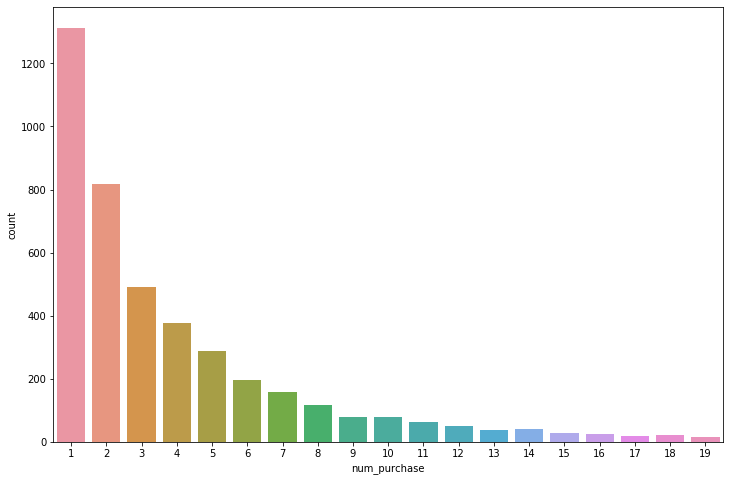

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(cust_df[(cust_df['num_purchase']>0)&(cust_df['num_purchase']<20)]['num_purchase'])
plt.show()

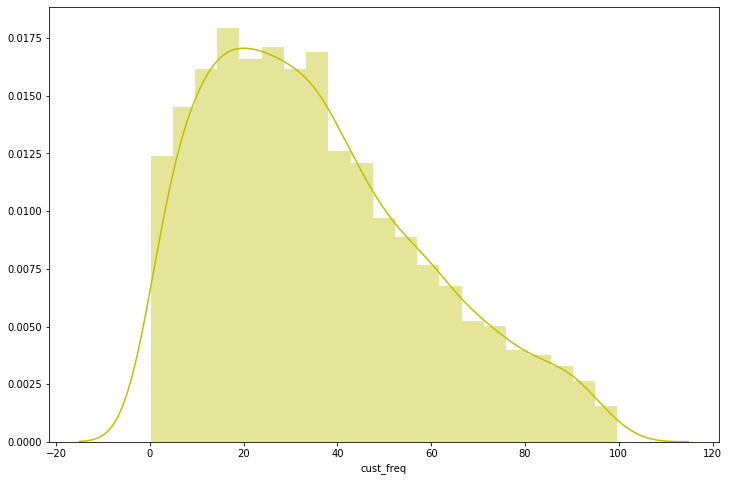

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(cust_df[(cust_df['cust_freq']>0)&(cust_df['cust_freq']<100)]['cust_freq'], color='y')
plt.show()

### Feature Engineering

In [12]:
df = df[df['Quantity']>0]

In [13]:
df1 = df.groupby(['CustomerID', 'InvoiceNo']).agg(total_purchase= pd.NamedAgg(column='net_sales', aggfunc='sum'),
                                           date= pd.NamedAgg(column='InvoiceDate', aggfunc= lambda x: max(x).date())).reset_index()

In [14]:
df1.head()

,CustomerID,InvoiceNo,total_purchase,date
0,12346.0,541431,77183.60,2011-01-18
1,12347.0,537626,711.79,2010-12-07
2,12347.0,542237,475.39,2011-01-26
3,12347.0,549222,636.25,2011-04-07
4,12347.0,556201,382.52,2011-06-09


In [15]:
df1['date'] = pd.to_datetime(df1['date'])

In [16]:
df2 = df1.groupby(['CustomerID', pd.Grouper(key='date', freq='3M')] ).agg(total_sales = pd.NamedAgg(column='total_purchase', aggfunc='sum'),
                                                                   avg_sales = pd.NamedAgg(column='total_purchase', aggfunc='mean'),
                                                                   num_sales = pd.NamedAgg(column='total_purchase', aggfunc='count')).reset_index()

In [17]:
df2.head()

,CustomerID,date,total_sales,avg_sales,num_sales
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


In [18]:
df2['date'].unique()

array(['2011-03-31T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-09-30T00:00:00.000000000',
       '2011-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
df2.loc[df2['date']=='2010-12-31','Quarter'] = 'Q1'
df2.loc[df2['date']=='2011-3-31','Quarter'] = 'Q2'
df2.loc[df2['date']=='2011-6-30','Quarter'] = 'Q3'
df2.loc[df2['date']=='2011-9-30','Quarter'] = 'Q4'
df2.loc[df2['date']=='2011-12-31','Quarter'] = 'Q5'

In [20]:
df2.head()

,CustomerID,date,total_sales,avg_sales,num_sales,Quarter
0,12346.0,2011-03-31,77183.60,77183.600,1,Q2
1,12347.0,2010-12-31,711.79,711.790,1,Q1
2,12347.0,2011-03-31,475.39,475.390,1,Q2
3,12347.0,2011-06-30,1018.77,509.385,2,Q3
4,12347.0,2011-09-30,584.91,584.910,1,Q4


In [21]:
final_df = pd.pivot_table(df2.loc[df2['Quarter']!='Q5'], values=['total_sales', 'num_sales'], columns='Quarter', index='CustomerID', 
               aggfunc={'total_sales':np.sum, 'num_sales':np.sum}, fill_value=0).reset_index()

In [22]:
final_df.columns = ['_'.join(col) for col in final_df.columns]

In [23]:
final_df.columns = ['CustomerID', 'num_sales_Q1', 'num_sales_Q2', 'num_sales_Q3',
       'num_sales_Q4', 'total_sales_Q1', 'total_sales_Q2', 'total_sales_Q3',
       'total_sales_Q4']

In [24]:
final_df.head()

,CustomerID,num_sales_Q1,num_sales_Q2,num_sales_Q3,num_sales_Q4,total_sales_Q1,total_sales_Q2,total_sales_Q3,total_sales_Q4
0,12346.0,0,1,0,0,0.00,77183.60,0.00,0.00
1,12347.0,1,1,2,1,711.79,475.39,1018.77,584.91
2,12348.0,1,1,1,1,892.80,227.44,367.00,310.00
3,12350.0,0,1,0,0,0.00,334.40,0.00,0.00
4,12352.0,0,5,0,2,0.00,1561.81,0.00,632.50


In [25]:
temp = df2.loc[df2['Quarter']=='Q5'].groupby(['CustomerID'])['total_sales'].sum().reset_index()

In [26]:
temp.columns = ['CustomerID', 'Q5_sales']

In [27]:
final_df = final_df.merge(temp, on='CustomerID')

In [28]:
final_df.head()

,CustomerID,num_sales_Q1,num_sales_Q2,num_sales_Q3,num_sales_Q4,total_sales_Q1,total_sales_Q2,total_sales_Q3,total_sales_Q4,Q5_sales
0,12347.0,1,1,2,1,711.79,475.39,1018.77,584.91,1519.14
1,12352.0,0,5,0,2,0.00,1561.81,0.00,632.50,311.73
2,12356.0,0,1,1,0,0.00,2271.62,481.46,0.00,58.35
3,12358.0,0,0,0,1,0.00,0.00,0.00,484.86,683.20
4,12359.0,0,2,1,0,0.00,2386.41,1109.32,0.00,2876.85


### Model & Performance

In [29]:
y = final_df['Q5_sales']
X = final_df.drop(['CustomerID', 'Q5_sales'], axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [31]:
model = LinearRegression()

In [32]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
y_pred = pd.DataFrame(model.predict(X_test))

In [34]:
y_test.reset_index(drop=True, inplace=True)

In [35]:
y_pred.reset_index(drop=True, inplace=True)

In [36]:
pd.concat([y_pred, y_test], axis=1)

,0,Q5_sales
0,931.239889,300.76
1,2398.972818,4385.71
2,2097.719912,2037.44
3,603.349070,105.00
4,1686.763859,821.73
...,...,...
271,665.831905,1181.52
272,1116.914319,161.46
273,391.101226,78.75
274,1303.544496,1324.30


In [37]:
model.intercept_

364.3913406178433

In [38]:
model.coef_

array([-4.94473003e+01, -9.17343420e+01, -2.24624161e+01,  1.65621560e+02,
        9.82285624e-01, -1.63803264e-02,  3.85393064e-01,  2.73846787e-01])

In [39]:
r2_score(y_test, y_pred)

0.8013386822073624